In [1]:
%%capture
!pip install /kaggle/input/ensemble-boxes/ensemble_boxes-1.0.0-py3-none-any.whl
!mkdir -p /root/.cache/torch/checkpoints
!cp /kaggle/input/resnet50/resnet50-19c8e357.pth /root/.cache/torch/checkpoints/

In [2]:
import os

import numpy as np
import pandas as pd

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from ensemble_boxes import *

In [3]:
# Constants
DATA_DIR = '/kaggle/input/global-wheat-detection'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 2
DETECTION_THRESHOLD = 0.40

In [4]:
def get_model(model_type):
    
    if model_type == 'resnet101':
        # Reference: https://stackoverflow.com/questions/58362892/resnet-18-as-backbone-in-faster-r-cnn
        resnet_net = torchvision.models.resnet101(pretrained=False) 
        modules = list(resnet_net.children())[:-2]

        backbone = nn.Sequential(*modules)
        backbone.out_channels = 2048

        anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                           aspect_ratios=((0.5, 1.0, 2.0),))


        # put the pieces together inside a FasterRCNN model
        model = FasterRCNN(backbone,
                           num_classes=2,
                           rpn_anchor_generator=anchor_generator)
        return model
    elif model_type == 'resnet50':
        # load a model pre-trained pre-trained on COCO
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

        # replace the classifier with a new one, that has
        # num_classes which is user-defined
        num_classes = 2  # 1 class (wheat heads) + background

        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features

        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        return model
    else:
        raise ValueError('Got invalid model. Supported models are: resnet50, resnet101')

In [5]:
def load_model(model_type, model_path):
    model = get_model(model_type)
    # Load the pretrained weights
    model.to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    return model

In [6]:
models = [
    load_model('resnet50', '/kaggle/input/resnet506582/fasterrcnn_augmented_20.pth'),
    load_model('resnet101', '/kaggle/input/resnet101trainedmodel/fasterrcnn__resnet101_augmented_16.pth')
]

In [7]:
class WheatDataset(Dataset):
    
    def __init__(self, image_ids, transforms):
        self.image_ids = image_ids
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index][:-4]
        image = cv2.imread(os.path.join(DATA_DIR, 'test', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        return image_id, image

In [8]:
def make_ensemble_predictions(images):
    images = list(image.to(DEVICE) for image in images)    
    result = []
    for net in models:
        outputs = net(images)
        result.append(outputs)
    return result

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.55, skip_box_thr=0.7, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

def collate_fn(batch):
    return tuple(zip(*batch))

def get_test_transforms():
    return albumentations.Compose([
                ToTensorV2(p=1.0)
            ])

In [9]:
test_dataset = WheatDataset(os.listdir(os.path.join(DATA_DIR, 'test')), get_test_transforms())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [10]:
results = []

for image_ids, images in test_data_loader:
    predictions = make_ensemble_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [11]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,796707dd7,0.9926 899 332 99 88 0.9902 944 71 77 102 0.98...
1,cc3532ff6,0.9968 261 641 106 168 0.9966 3 412 149 106 0....
2,51f1be19e,0.9935 273 469 143 120 0.9921 613 86 154 163 0...
3,51b3e36ab,0.9972 827 445 196 156 0.9968 231 639 99 161 0...
4,f5a1f0358,0.9944 883 639 91 148 0.9944 139 754 161 116 0...


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


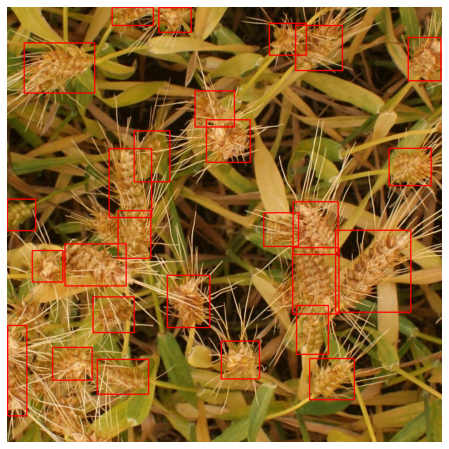

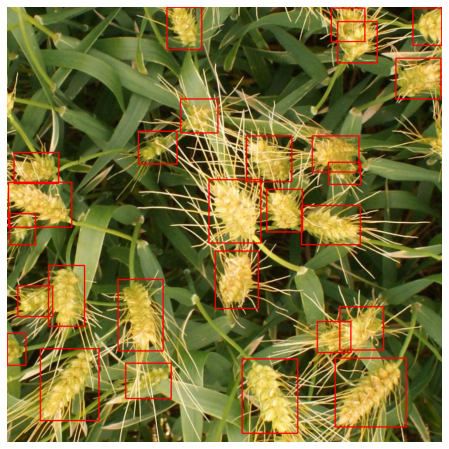

In [12]:
import matplotlib.pyplot as plt

image_ids, images = next(iter(test_data_loader))
predictions = make_ensemble_predictions(images)

for i in range(2):
    sample = images[i].permute(1,2,0).cpu().numpy()
    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=1023)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(sample)
    plt.show()